In [1]:
import pandas as pd
import numpy as np
import openpyxl
from openpyxl.chart import LineChart, Reference
from datetime import datetime

## Part 1: First Sheet Creation

In [2]:
# import first csv for month * device aggregation
sessions = pd.read_csv('DataAnalyst_Ecom_data_sessionCounts.csv')

sessions.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY
0,Safari,tablet,7/1/12,2928,127,221
1,Internet Explorer,desktop,7/1/12,1106,28,0
2,Chrome,tablet,7/1/12,474,3,13
3,Amazon Silk,tablet,7/1/12,235,4,5
4,Internet Explorer,mobile,7/1/12,178,6,11


In [3]:
# convert date column to month-year for grouping
sessions['dim_date'] = pd.to_datetime(sessions['dim_date'])
sessions['month_year'] = sessions['dim_date'].dt.to_period('M')

# sort by newest to oldest
sessions.sort_values(by=['month_year', 'dim_deviceCategory'], ascending=False, inplace=True)

sessions.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY,month_year
6909,Safari,tablet,2013-06-01,18211,706,1317,2013-06
6916,Safari (in-app),tablet,2013-06-01,1103,4,1,2013-06
6917,Chrome,tablet,2013-06-01,778,5,19,2013-06
6919,Internet Explorer,tablet,2013-06-01,210,7,0,2013-06
6920,Amazon Silk,tablet,2013-06-01,144,0,3,2013-06


In [4]:
# group by month and device, summing up values
sessions_month = sessions.groupby(['month_year', 'dim_deviceCategory'], as_index=False).agg({'sessions':'sum', 'transactions':'sum', 'QTY':'sum'})

sessions_month.sort_values(by=['month_year', 'dim_deviceCategory'], ascending=True, inplace=True)

# change datetime to have slash and not dash for formatting convenience in excel
sessions_month['month_year'] = sessions_month['month_year'].dt.strftime('%m/%Y')

sessions_month.head()

,month_year,dim_deviceCategory,sessions,transactions,QTY
0,07/2012,desktop,335429,10701,18547
1,07/2012,mobile,274443,2576,4557
2,07/2012,tablet,158717,4884,8700
3,08/2012,desktop,392079,12912,23316
4,08/2012,mobile,275556,3165,5572


In [5]:
# create ecomm conversion rate metric (ECR)
sessions_month['ECR'] = round(sessions_month['transactions'] / sessions_month['sessions'], 4)

sessions_month.head()

,month_year,dim_deviceCategory,sessions,transactions,QTY,ECR
0,07/2012,desktop,335429,10701,18547,0.0319
1,07/2012,mobile,274443,2576,4557,0.0094
2,07/2012,tablet,158717,4884,8700,0.0308
3,08/2012,desktop,392079,12912,23316,0.0329
4,08/2012,mobile,275556,3165,5572,0.0115


## Part 2: Second Sheet Creation

In [6]:
# import csv of second file with add to cart data
atc = pd.read_csv('DataAnalyst_Ecom_data_addsToCart.csv')

atc.head()

,dim_year,dim_month,addsToCart
0,2012,7,191504
1,2012,8,217666
2,2012,9,123726
3,2012,10,139803
4,2012,11,186572


In [7]:
# combine month and year to one column and then format the same as sheet 1
atc['month_year']=pd.to_datetime(atc['dim_year'].astype(str) + atc['dim_month'].astype(str), format='%Y%m')
atc['month_year'] = pd.to_datetime(atc['month_year'])
atc['month_year'] = atc['month_year'].dt.to_period('M')

# change datetime to have slash and not dash for formatting convenience in excel
atc['month_year'] = atc['month_year'].dt.strftime('%m/%Y')

atc.head()

,dim_year,dim_month,addsToCart,month_year
0,2012,7,191504,07/2012
1,2012,8,217666,08/2012
2,2012,9,123726,09/2012
3,2012,10,139803,10/2012
4,2012,11,186572,11/2012


In [8]:
# group sessions df by just month
sessions_grouped = sessions.groupby('month_year', as_index=False).agg({'sessions':'sum', 'transactions':'sum', 'QTY':'sum'})
sessions_grouped['ECR'] = round(sessions_grouped['transactions'] / sessions_grouped['sessions'], 4)

sessions_grouped['month_year'] = sessions_grouped['month_year'].dt.strftime('%m/%Y')

sessions_grouped.head()

,month_year,sessions,transactions,QTY,ECR
0,07/2012,768589,18161,31804,0.0236
1,08/2012,822493,19279,34648,0.0234
2,09/2012,662653,15658,28426,0.0236
3,10/2012,648639,14275,26626,0.0220
4,11/2012,637780,15527,28132,0.0243


In [9]:
# merge both dataframes
combined = pd.merge(sessions_grouped, atc[['month_year', 'addsToCart']], left_on='month_year', right_on='month_year', how='left')

combined.head(10)

,month_year,sessions,transactions,QTY,ECR,addsToCart
0,07/2012,768589,18161,31804,0.0236,191504
1,08/2012,822493,19279,34648,0.0234,217666
2,09/2012,662653,15658,28426,0.0236,123726
3,10/2012,648639,14275,26626,0.0220,139803
4,11/2012,637780,15527,28132,0.0243,186572
5,12/2012,789634,19929,34752,0.0252,168972
6,01/2013,899992,21560,38846,0.0240,147619
7,02/2013,550227,14166,27048,0.0257,135882
8,03/2013,788820,17804,32082,0.0226,109797
9,04/2013,1296613,30369,54946,0.0234,183842


In [10]:
# create add to cart rate
combined['atc_rate'] = round(combined['addsToCart'] / combined['sessions'], 4)

In [11]:
# get two most recent months
combined['month_year'] = pd.to_datetime(combined['month_year'])
combined['month_year'] = combined['month_year'].dt.to_period('M')
combined.sort_values(by=['month_year'], ascending=True, inplace=True)
most_recent = combined[-2:]

# change datetime to have slash and not dash for formatting convenience in excel
most_recent['month_year'] = most_recent['month_year'].dt.strftime('%m/%Y')

# reset index so any changes are always the same indeces moving forward
most_recent.reset_index(drop=True, inplace=True)
most_recent.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_26668\3371613063.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_recent['month_year'] = most_recent['month_year'].dt.strftime('%m/%Y')


,month_year,sessions,transactions,QTY,ECR,addsToCart,atc_rate
0,05/2013,1164639,28389,51629,0.0244,136720,0.1174
1,06/2013,1388834,34538,61891,0.0249,107970,0.0777


In [12]:
# calculate difference between two months
subtraction = most_recent.iloc[1, 1:] - most_recent.iloc[0, 1:]

# turn it into a dataframe
subtraction = pd.DataFrame(subtraction)
subtraction = subtraction.transpose()

subtraction['month_year'] = 'Absolute Change'
subtraction

,sessions,transactions,QTY,ECR,addsToCart,atc_rate,month_year
0,224195,6149,10262,0.0005,-28750,-0.0397,Absolute Change


In [13]:
# calculate percent difference between two months
division = (most_recent.iloc[1, 1:] - most_recent.iloc[0, 1:]) / most_recent.iloc[0, 1:]

# turn it into a dataframe
division = pd.DataFrame(division)
division = division.transpose()
division = division.astype(float).round(4)

division['month_year'] = 'Percent Change'
division

,sessions,transactions,QTY,ECR,addsToCart,atc_rate,month_year
0,0.1925,0.2166,0.1988,0.0205,-0.2103,-0.3382,Percent Change


In [14]:
# add as bottom row
most_recent = pd.concat([most_recent, subtraction, division])

In [15]:
most_recent

,month_year,sessions,transactions,QTY,ECR,addsToCart,atc_rate
0,05/2013,1164639,28389,51629,0.0244,136720,0.1174
1,06/2013,1388834,34538,61891,0.0249,107970,0.0777
0,Absolute Change,224195,6149,10262,0.0005,-28750,-0.0397
0,Percent Change,0.1925,0.2166,0.1988,0.0205,-0.2103,-0.3382


## Write to Excel

In [16]:
# add dataframes to excel workbook
with pd.ExcelWriter('david_bardasz_ixis.xlsx') as writer:  
    sessions_month.to_excel(writer, sheet_name='sessions_month_device', index=False)
    most_recent.to_excel(writer, sheet_name='MoM_comparison', index=False)

In [17]:
# edit first sheet for formatting
wb = openpyxl.load_workbook('david_bardasz_ixis.xlsx')
sheet = wb.get_sheet_by_name('sessions_month_device')

C:\Users\PC\AppData\Local\Temp\ipykernel_26668\541351407.py:3: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  sheet = wb.get_sheet_by_name('sessions_month_device')


In [18]:
# change column widths so all values are viewable
sheet.column_dimensions['A'].width = 12
sheet.column_dimensions['B'].width = 19
sheet.column_dimensions['C'].width = 8
sheet.column_dimensions['D'].width = 12
sheet.column_dimensions['E'].width = 6
sheet.column_dimensions['F'].width = 12

In [19]:
# change column widths in sheet 2
sheet2 = wb.get_sheet_by_name('MoM_comparison')
sheet2.column_dimensions['A'].width = 16
sheet2.column_dimensions['B'].width = 12
sheet2.column_dimensions['C'].width = 12
sheet2.column_dimensions['D'].width = 11
sheet2.column_dimensions['E'].width = 12
sheet2.column_dimensions['F'].width = 12
sheet2.column_dimensions['G'].width = 12

wb.save('david_bardasz_ixis.xlsx')

C:\Users\PC\AppData\Local\Temp\ipykernel_26668\1575624630.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  sheet2 = wb.get_sheet_by_name('MoM_comparison')


In [20]:
import matplotlib.pyplot as plt

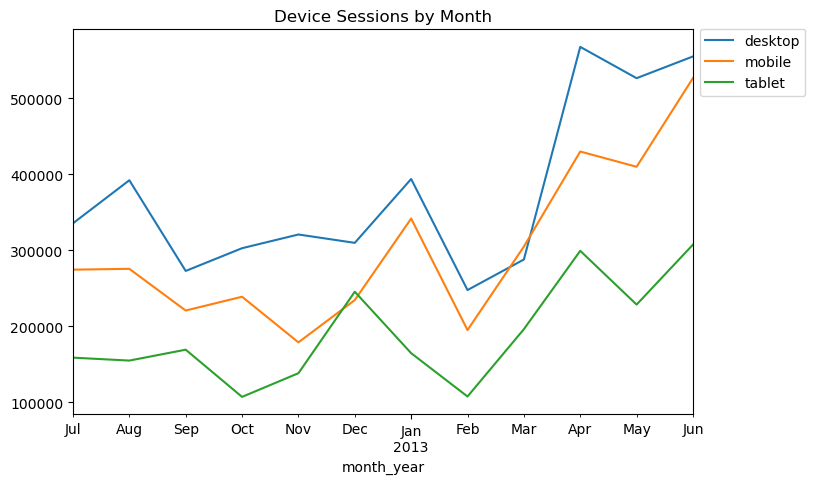

In [21]:
# turn month year back into datetime for formatting
sessions_month['month_year'] = pd.to_datetime(sessions_month['month_year'])
sessions_month['month_year'] = sessions_month['month_year'].dt.to_period('M')
# create a pivotable for plotting
dfp = sessions_month.pivot_table(index='month_year', columns='dim_deviceCategory', values='sessions', aggfunc='sum')

# plot line graph for device sessions by month
ax = dfp.plot(figsize=(8, 5))
ax.set_title('Device Sessions by Month')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

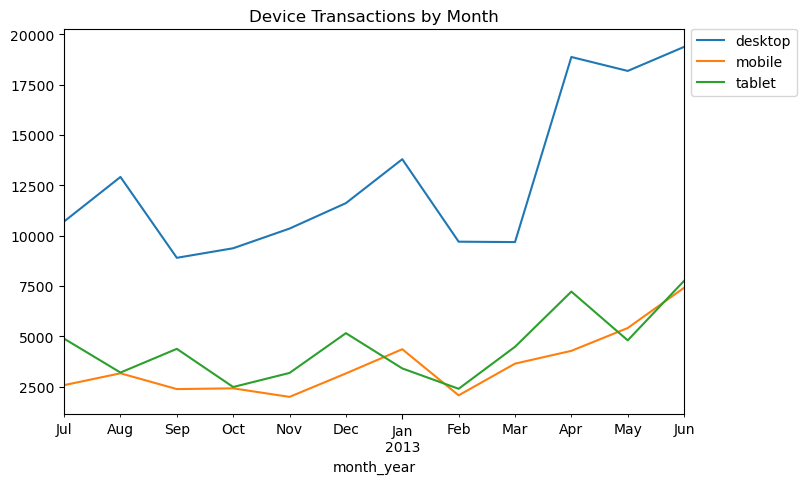

In [22]:
# reshape the dataframe
dfp = sessions_month.pivot_table(index='month_year', columns='dim_deviceCategory', values='transactions', aggfunc='sum')

# plot line graph for device transactions by month
ax = dfp.plot(figsize=(8, 5))
ax.set_title('Device Transactions by Month')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

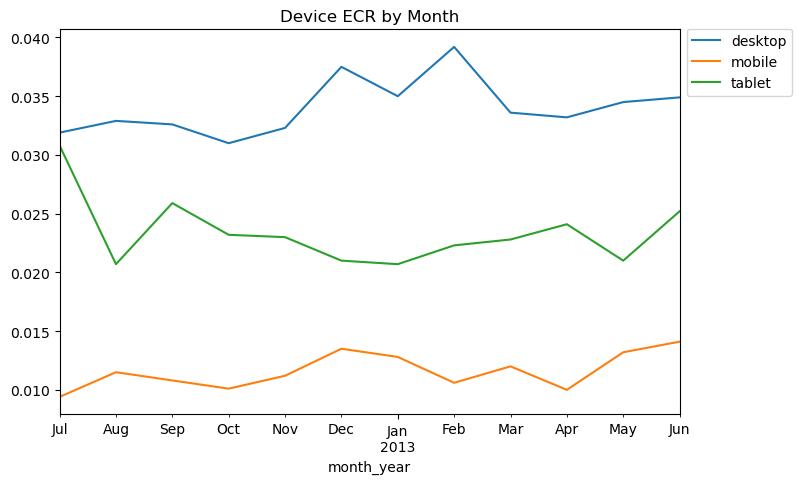

In [23]:
# reshape the dataframe
dfp = sessions_month.pivot_table(index='month_year', columns='dim_deviceCategory', values='ECR', aggfunc='sum')

# plot line graph for device sessions by month
ax = dfp.plot(figsize=(8, 5))
ax.set_title('Device ECR by Month')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')